,Country,Date_of_Consumption_and_Loss_Electricity,Electricity_Consumption,Loss_electricity,Year_of_Emissions_of_CarbonDioxide_Electricity,Emissions_CarbonDioxide_ElectricityGeneration
1,Andorra,2019,4.898400e+08,6.565000e+07,2021,115000.0
3,Armenia,2018,5.402561e+09,6.114350e+08,2021,1845000.0
4,Austria,2018,6.307400e+10,3.459000e+09,2021,12158000.0
5,Azerbaijan,2018,1.781150e+10,2.219800e+09,2021,16250000.0
6,Belgium,2018,8.275500e+10,3.798000e+09,2021,18000000.0


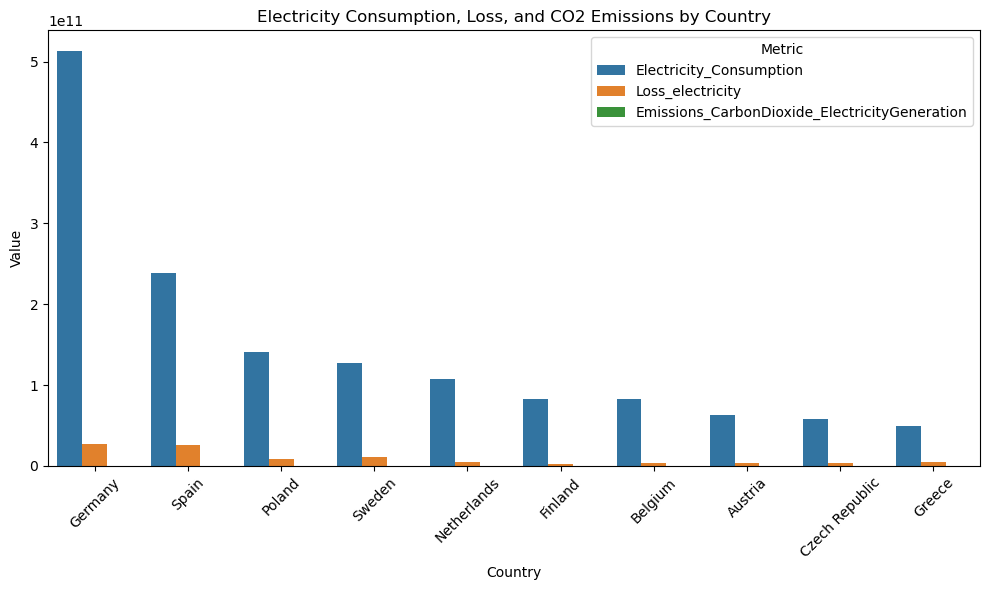

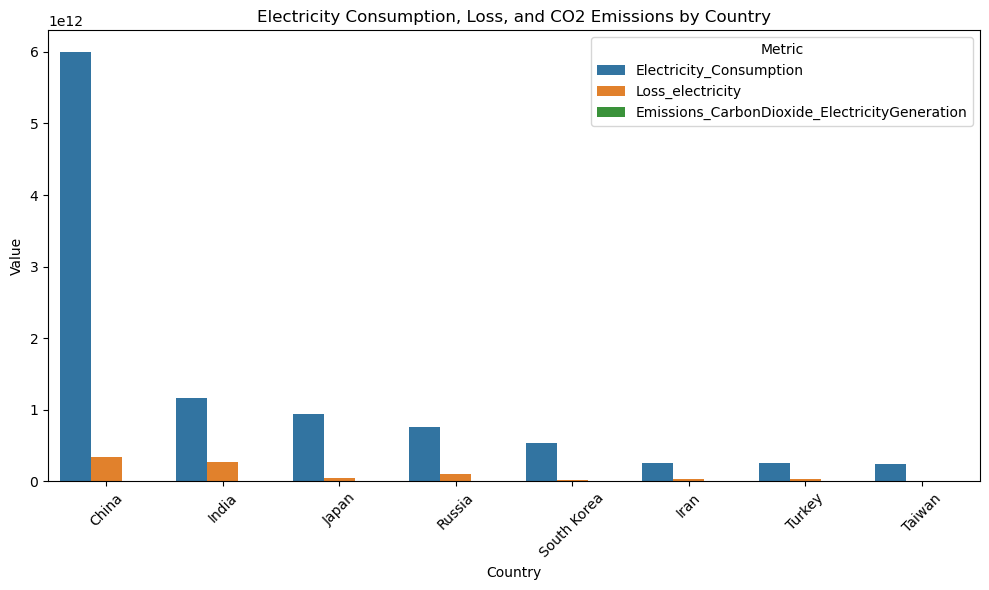

In [1]:
from functions import *
import pandas as pd


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

main()